# Portfolio Optimization

In [1]:
# 사전 준비

# import libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# plot style settings
plt.style.use('seaborn-whitegrid')
plt.rc('font', family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)

## 데이터 준비

### 대상 데이터 선택

최종 선택 데이터 - 융기원 데이터 기준에 금(Gold) 추가

| 자산군 | 세부자산군 | Bloomberg Ticker | ETF |
| --- | --- | --- | --- |
| 주식 | 국내주식 | KOSPI INDEX |  |
|  | 선진국주식 | M1WO INDEX |  |
|  | 신흥국주식 | M1EF INDEX |  |
| 채권 | 국내채권 | KBPMABIN INDEX |  |
|  | 선진국채권 | BTSYTRUH INDEX |  |
|  | 신흥국채권 | JPEIGLBL INDEX |  |
|  | 해외크레딧 | LGCPTRUU INDEX |  |
| 대체 | 부동산 | RUGL INDEX |  |
|  | 원자재 | BCOMTR INDEX |  |
|  | 금 | BCOMGCTR INDEX |  |
|  | 유동성 | US0003M INDEX |  |

### 데이터 로딩

In [2]:
# 사전작업: ./data 폴더의 BloombergMain.py (융기원 코드) 활용하여 .csv 형태로 준비

data = pd.read_csv('./data/data.csv', index_col=0, parse_dates=True)
df = data.dropna(thresh=4)
# df = pd.read_csv('https://raw.githubusercontent.com/suhan-jung/portfolio_optimization/master/data/data.csv', index_col=0, parse_dates=True) # 구글 코랩등 사용을 위해 외부 링크로 준비
df = df.interpolate(method='linear', limit_direction='forward') # 연휴에 따른 급격한 변화를 smoothing해주는 것이 필요함
# df_dropna = df.dropna() # NA는 행 자체를 삭제(대세에 지장 없음) 하지만 장기적으로는 휴일 관련 interpolation을 통해 연휴에 따른 급격한 변화를 smoothing해주는 것이 필요함
print(df.shape)
df = df.dropna()
print(df.shape)
# df.columns = ["국내주식","선진국주식","신흥국주식","국내채권","선진국채권","신흥국채권","해외크레딧","부동산","원자재","금"]
df.head()


(4284, 15)
(2773, 15)


DBE US Equity  IAU US Equity  SLV US Equity  AIA US Equity  \
Date                                                                     
2011-01-28        26.8877         26.080         27.300        37.4524   
2011-01-31        27.3224         26.020         27.392        37.5632   
2011-02-01        27.3804         26.180         27.870        38.2043   
2011-02-02        27.6992         26.140         27.690        38.2043   
2011-02-03        27.5930         26.465         28.285        38.1568   

            VPL US Equity  VGK US Equity  VWO US Equity  VXUS US Equity  \
Date                                                                      
2011-01-28        41.8454        34.6038        34.4582         35.6919   
2011-01-31        42.0521        35.1213        34.8177         36.0899   
2011-02-01        42.7534        35.9079        35.5666         36.8641   
2011-02-02        43.0560        35.7216        35.2903         36.6759   
2011-02-03        43.4029        35.5905        35.2596         36.7411   

            RWO US Equity  VOO US Equity  VO US Equity  VB US Equity  \
Date                                                                   
2011-01-28        25.2969        94.1996       64.4520       61.8237   
2011-01-31        25.6031        94.9222       64.9558       62.2921   
2011-02-01        25.8686        96.4061       65.9975       63.5356   
2011-02-02        25.7801        96.2448       65.8438       63.2375   
2011-02-03        25.8890        96.4868       66.2281       63.6037   

            SCHH US Equity  EMLC US Equity  AGG US Equity  
Date                                                       
2011-01-28         19.4065         29.0824        80.4215  
2011-01-31         19.6777         29.0049        80.2695  
2011-02-01         19.7379         29.1022        80.0989  
2011-02-02         19.7153         29.1022        80.0075  
2011-02-03         19.7967         28.9865        79.7103

### 기초 데이터 산출

#### 수익율 계산


$$ 단순수익율\ R_{t} = \frac{P_{t}-P_{t-1}}{P_{t-1}} $$

In [20]:
df.head(10)

DBE US Equity  IAU US Equity  SLV US Equity  AIA US Equity  \
Date                                                                     
2011-01-28        26.8877         26.080         27.300        37.4524   
2011-01-31        27.3224         26.020         27.392        37.5632   
2011-02-01        27.3804         26.180         27.870        38.2043   
2011-02-02        27.6992         26.140         27.690        38.2043   
2011-02-03        27.5930         26.465         28.285        38.1568   
2011-02-04        27.1872         26.370         28.400        38.3546   
2011-02-07        27.0326         26.395         28.660        38.0618   
2011-02-08        27.1775         26.680         29.640        37.9272   
2011-02-09        27.4674         26.680         29.518        37.1120   
2011-02-10        27.1968         26.640         29.460        36.5184   

            VPL US Equity  VGK US Equity  VWO US Equity  VXUS US Equity  \
Date                                                                      
2011-01-28        41.8454        34.6038        34.4582         35.6919   
2011-01-31        42.0521        35.1213        34.8177         36.0899   
2011-02-01        42.7534        35.9079        35.5666         36.8641   
2011-02-02        43.0560        35.7216        35.2903         36.6759   
2011-02-03        43.4029        35.5905        35.2596         36.7411   
2011-02-04        43.4620        35.5215        35.2446         36.7194   
2011-02-07        43.4472        35.7147        35.1457         36.8207   
2011-02-08        43.5801        35.9907        35.0499         36.8785   
2011-02-09        43.2479        36.0321        34.3684         36.6542   
2011-02-10        43.1224        35.6181        34.0239         36.3142   

            RWO US Equity  VOO US Equity  VO US Equity  VB US Equity  \
Date                                                                   
2011-01-28        25.2969        94.1996       64.4520       61.8237   
2011-01-31        25.6031        94.9222       64.9558       62.2921   
2011-02-01        25.8686        96.4061       65.9975       63.5356   
2011-02-02        25.7801        96.2448       65.8438       63.2375   
2011-02-03        25.8890        96.4868       66.2281       63.6037   
2011-02-04        25.7324        96.7449       66.5526       63.8336   
2011-02-07        25.8617        97.3564       66.9624       64.4809   
2011-02-08        25.8958        97.8094       67.1930       64.9153   
2011-02-09        25.8005        97.5675       66.9454       64.6555   
2011-02-10        25.7392        97.5997       67.2698       64.9706   

            SCHH US Equity  EMLC US Equity  AGG US Equity  
Date                                                       
2011-01-28         19.4065         29.0824        80.4215  
2011-01-31         19.6777         29.0049        80.2695  
2011-02-01         19.7379         29.1022        80.0989  
2011-02-02         19.7153         29.1022        80.0075  
2011-02-03         19.7967         28.9865        79.7103  
2011-02-04         19.5865         29.0577        79.4436  
2011-02-07         19.8125         28.8131        79.4741  
2011-02-08         19.8811         28.9242        79.2455  
2011-02-09         19.9029         28.9353        79.3903  
2011-02-10         19.9707         28.7684        79.1617

In [21]:
df_w = df.resample('W', closed='right').last()
df_w.head(10)

DBE US Equity  IAU US Equity  SLV US Equity  AIA US Equity  \
Date                                                                     
2011-01-30        26.8877          26.08        27.3000        37.4524   
2011-02-06        27.1872          26.37        28.4000        38.3546   
2011-02-13        27.0423          26.51        29.2100        36.4393   
2011-02-20        27.2258          27.12        31.7875        37.1041   
2011-02-27        29.0229          27.54        32.5600        36.1385   
2011-03-06        29.9407          27.92        34.6925        36.8121   
2011-03-13        29.3224          27.70        35.0290        36.2810   
2011-03-20        29.5929          27.72        34.2700        35.2916   
2011-03-27        30.1822          27.90        36.3900        36.9036   
2011-04-03        30.7329          27.90        36.8600        38.3151   

            VPL US Equity  VGK US Equity  VWO US Equity  VXUS US Equity  \
Date                                                                      
2011-01-30        41.8454        34.6038        34.4582         35.6919   
2011-02-06        43.4620        35.5215        35.2446         36.7194   
2011-02-13        43.1187        35.7699        34.3946         36.4516   
2011-02-20        44.0820        36.3495        35.1210         37.0956   
2011-02-27        43.4767        35.8251        34.4601         36.5964   
2011-03-06        43.4989        35.9493        35.4918         36.9580   
2011-03-13        41.7052        35.1282        34.7278         36.0175   
2011-03-20        40.0665        34.5831        34.2560         35.3085   
2011-03-27        40.7161        35.4111        35.7913         36.2708   
2011-04-03        41.3730        36.3012        37.2592         37.1607   

            RWO US Equity  VOO US Equity  VO US Equity  VB US Equity  \
Date                                                                   
2011-01-30        25.2969        94.1996       64.4520       61.8237   
2011-02-06        25.7324        96.7449       66.5526       63.8336   
2011-02-13        25.8345        98.2126       67.7736       65.6775   
2011-02-20        26.1748        99.2611       68.6702       66.7208   
2011-02-27        26.0523        97.6320       67.4492       65.5370   
2011-03-06        26.0659        97.7449       67.6029       65.8862   
2011-03-13        25.7814        96.5352       66.5611       64.2084   
2011-03-20        25.3396        94.6641       65.7243       63.5781   
2011-03-27        25.6680        97.2591       67.7823       65.8233   
2011-04-03        26.2221        98.6686       69.1829       67.5779   

            SCHH US Equity  EMLC US Equity  AGG US Equity  
Date                                                       
2011-01-30         19.4065         29.0824        80.4215  
2011-02-06         19.5865         29.0577        79.4436  
2011-02-13         20.1206         28.7462        79.4741  
2011-02-20         20.1884         29.5361        79.7713  
2011-02-27         20.0920         29.2357        80.3504  
2011-03-06         19.8479         29.4508        80.2391  
2011-03-13         19.8811         29.4955        80.7052  
2011-03-20         19.6234         29.1379        80.9268  
2011-03-27         19.7226         29.7524        80.4149  
2011-04-03         20.2680         30.1591        80.4330

In [22]:
# simple return
dR = df.pct_change().dropna()
wR = df_w.pct_change().dropna()



$$ 로그수익율\ r_{t} = \ln P_{t}-\ln P_{t-1} $$

In [23]:
# log return
dr = np.log(df).diff(1).dropna()
wr = np.log(df_w).diff(1).dropna()

In [24]:
# 3M LIBOR와 같이 무위험 이자율 개념의 market data인경우 적용일수*적용이자율 산식으로 다른 항목과 동일한 수익율을 산출한다. (사용하지는 않을 예정)

# 유동성의 경우 3M LIBOR 이자율(%) 단위이므로 분리하여 처리한다.
# df_rf = df[['유동성']]
# df = df.drop(['유동성'], axis=1)
# df_rf.head()

# df_rf['R'] = (df_rf.index.to_series().diff(1).dt.days/365 * df_rf['유동성'].shift(1))
# df_rf['r'] = np.log(1+df_rf['R'])
# df_rf = df_rf.dropna()
# df_rf

In [25]:
# cumulative daily return
cdr = dr.cumsum()
cdR = (1+dR).cumprod()-1
# total sum of daily return
tdr = dr.sum() # total
tdR = (1+dR).prod()-1
# annualized daily return
adr = tdr/len(dr)*250
adR = (tdR+1)**(250/len(dr))-1

In [26]:
# standard deviation of daily return
sd_dr = dr.std()
sd_dR = dR.std()
# annualized standard deviation of daily return
asd_dr = sd_dr * np.sqrt(250)
asd_dR = sd_dR * np.sqrt(250)
# covariance of weekly return
cov_wr = wr.cov()
cov_wR = wR.cov()
# annualized covariance of weekly return
acov_wr = cov_wr * 52
acov_wR = cov_wR * 52
# correlation of weekly return
corr_wr = wr.corr()
corr_wR = wR.corr()

In [27]:
# yearly correlation of weekly return
ycorr_wr = wr.groupby(pd.Grouper(freq='Y')).corr()
ycorr_wR = wR.groupby(pd.Grouper(freq='Y')).corr()

In [28]:
# yearly return
yr = dr.groupby(pd.Grouper(freq='Y')).sum()
yR = (dR+1).groupby(pd.Grouper(freq='Y')).prod()-1
# yearly standard deviation of daily return
ysd_dr = dr.groupby(pd.Grouper(freq='Y')).std()*np.sqrt(250)
ysd_dR = dR.groupby(pd.Grouper(freq='Y')).std()*np.sqrt(250)

## 데이터 탐색

### 자산별/연도별 Risk-Return Plot

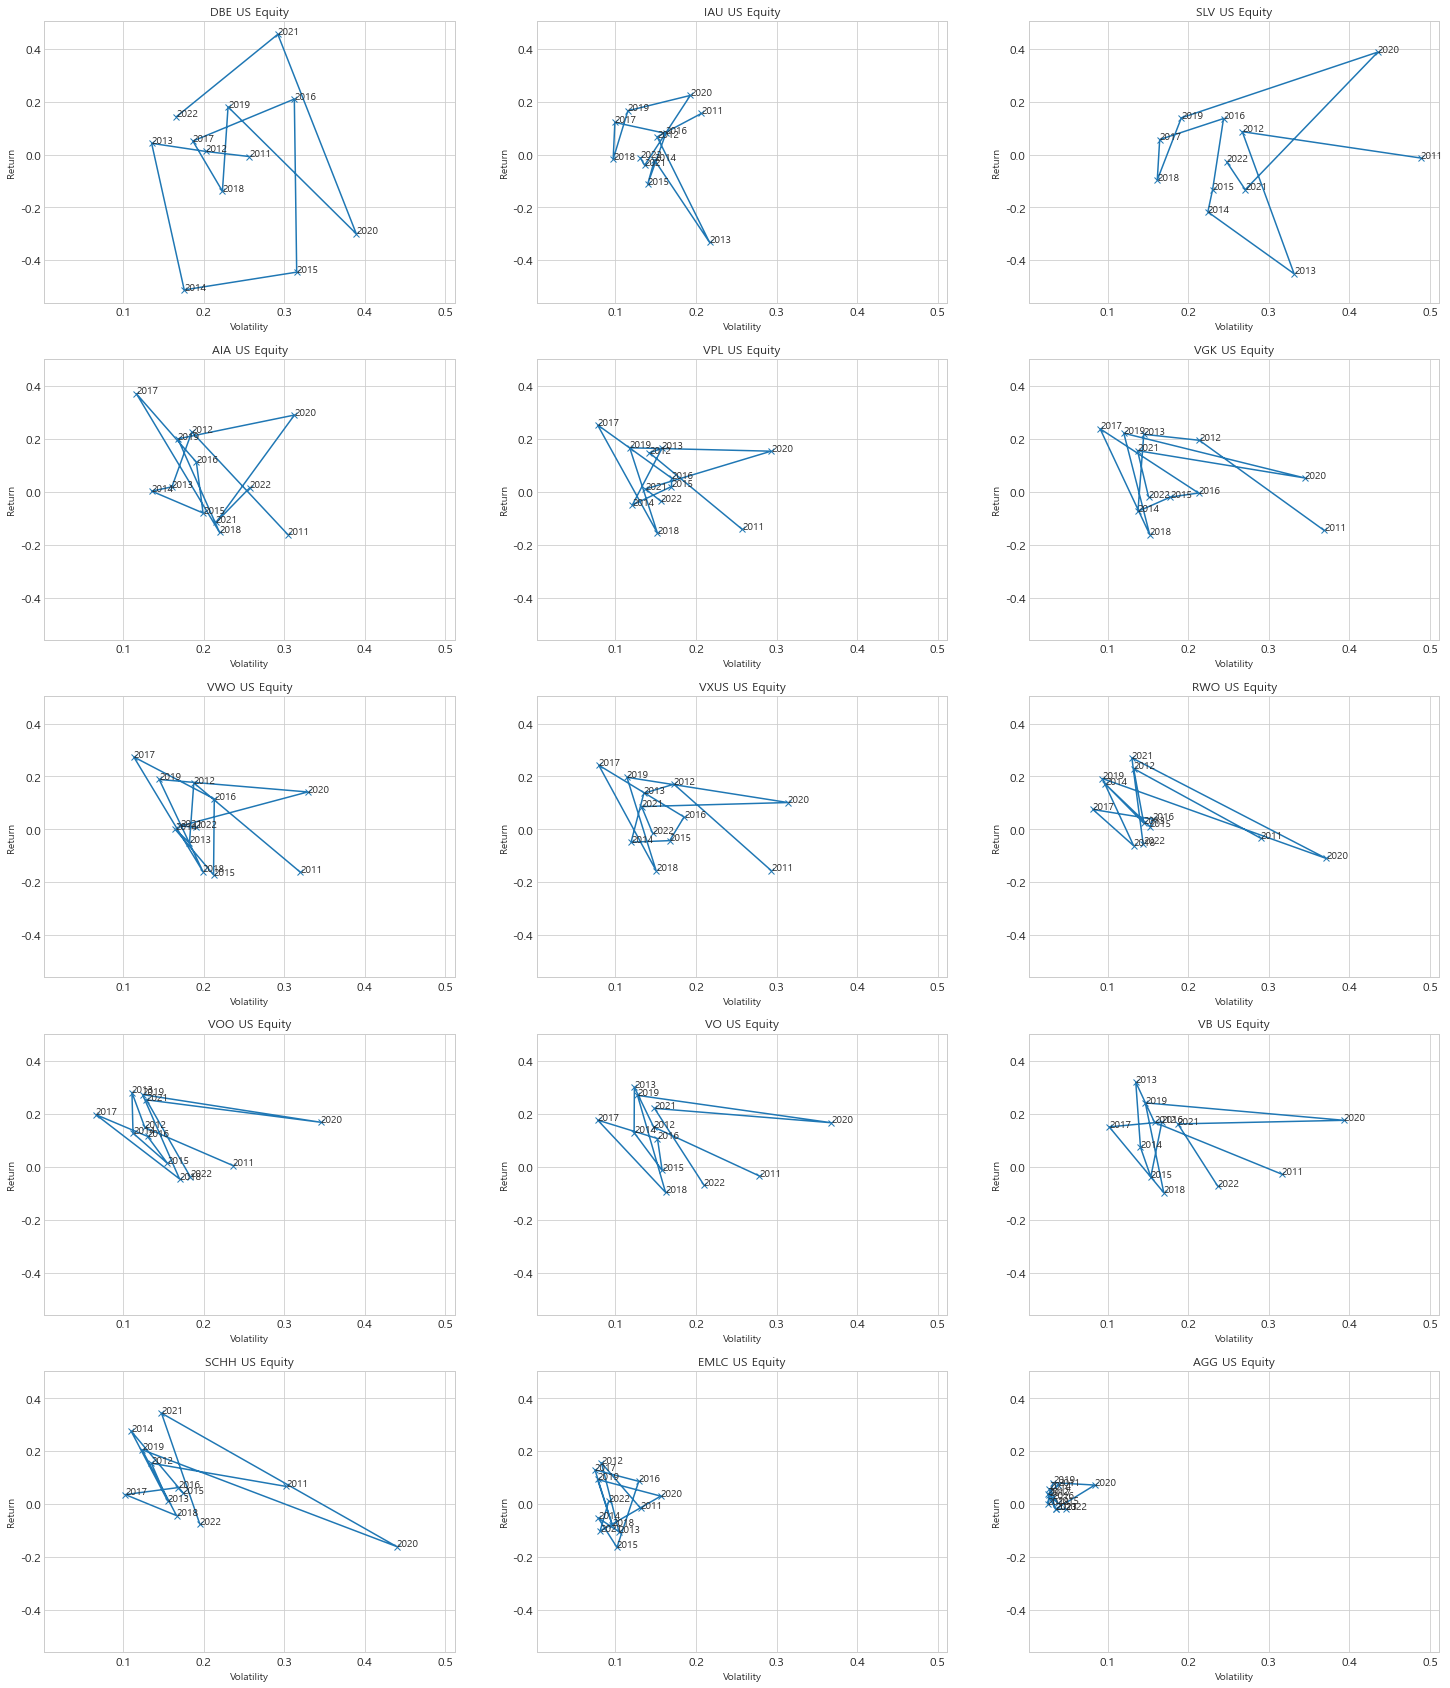

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl 
# j = 6
col = 3
fig, ax = plt.subplots(math.ceil(dr.shape[1]/col),col, figsize=(25,30), sharey=True, sharex=True)
# fig, ax = plt.subplots(6,2, figsize=(15,30))
for j in range(yr.shape[1]):
    x = j//col
    y= j%col
    ax[x][y].plot(ysd_dr.iloc[:,j], yr.iloc[:,j], marker='x', alpha=1.0)
    # ax[x][y].plot(ysdr.iloc[:,j], yr.iloc[:,j]-yearly_rf.iloc[:,0], marker=j, alpha=1.0)
    ax[x][y].set_title(yr.columns[j])
    ax[x][y].set_xlabel('Volatility')
    ax[x][y].set_ylabel('Return')
    ax[x][y].tick_params(axis='both', which='both', labelsize=12, labelbottom=True, labelleft=True)
    for i, label in enumerate(yr.index):
        ax[x][y].text(ysd_dr.iloc[:,j][i], yr.iloc[:,j][i], f"{label.strftime('%Y')}")
        # ax[x][y].text(ysdr.iloc[:,j][i], yr.iloc[:,j][i]-yearly_rf.iloc[:,0][i], f"{label.strftime('%Y')}")
        # plt.text(ysdr.iloc[:,j][i], yr.iloc[:,j][i], f"{yr.iloc[:,j].name}-{label.strftime('%Y')}")
# plt.text(x.iloc[:,0],y.iloc[:,0], 'text', fontsize=10)
# plt.xlim(left=0)
# plt.ylim(bottom=-0.4)
# plt.xlabel('Volatility (Std. Deviation)')
# plt.ylabel('Expected Returns')
# plt.title('Risk-Return Profiles of Various Assets')

# 전체자산 추가 plotting
# ax[5][1].scatter(asdr, adr, marker="x", s=100, alpha=1.0)
# for i, label in enumerate(adr.index):
#     ax[5][1].text(asdr[i]+0.002, adr[i], label)
# ax[5][1].set_title("전체 자산")
# ax[5][1].set_xlabel('Volatility')
# ax[5][1].set_ylabel('Return')
# ax[5][1].tick_params(axis='both', which='both', labelsize=12, labelbottom=True, labelleft=True)
# plt.show()

### 전체자산 전체기간 연평균 Risk-Return plot

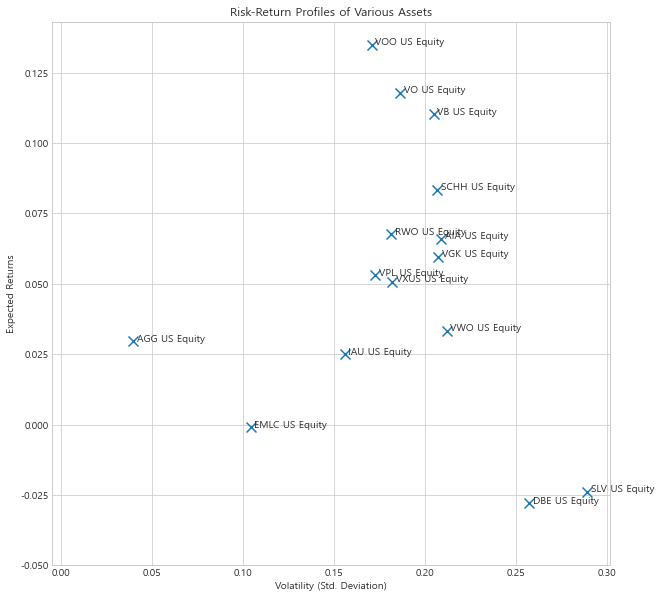

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl 
plt.figure(figsize=(10,10))
plt.scatter(asd_dr, adr, marker="x", s=100, alpha=1.0)
for i, label in enumerate(adr.index):
    plt.text(asd_dr[i]+0.002, adr[i], label)
plt.xlim(left=-0.005)
plt.ylim(bottom=-0.05)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Risk-Return Profiles of Various Assets')
plt.show()

### 상관계수

#### 전체기간-주간수익율 상관계수

<AxesSubplot:>

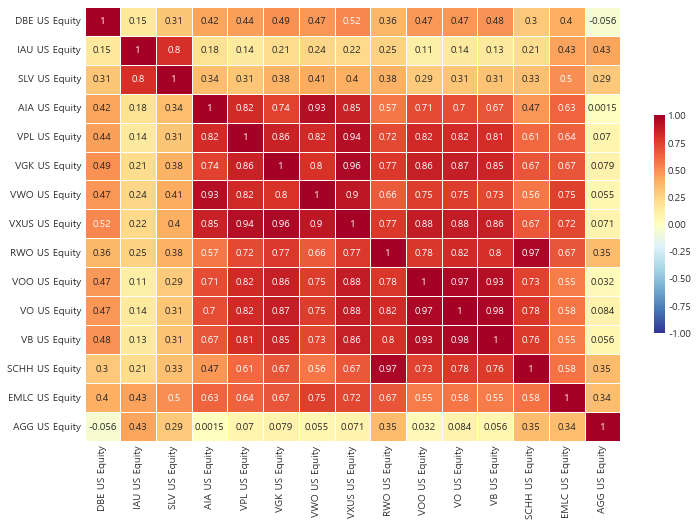

In [31]:
import seaborn as sns

plt.figure(figsize=(12,8))
# plt.style.use('seaborn-whitegrid')
# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr_wr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corr_wr, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            # mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  

#### 연도별 상관계수

C:\Users\user\AppData\Local\Temp/ipykernel_24140/504373167.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(ycorr_wr.loc[dateindex.year == 2011], dtype=np.bool)


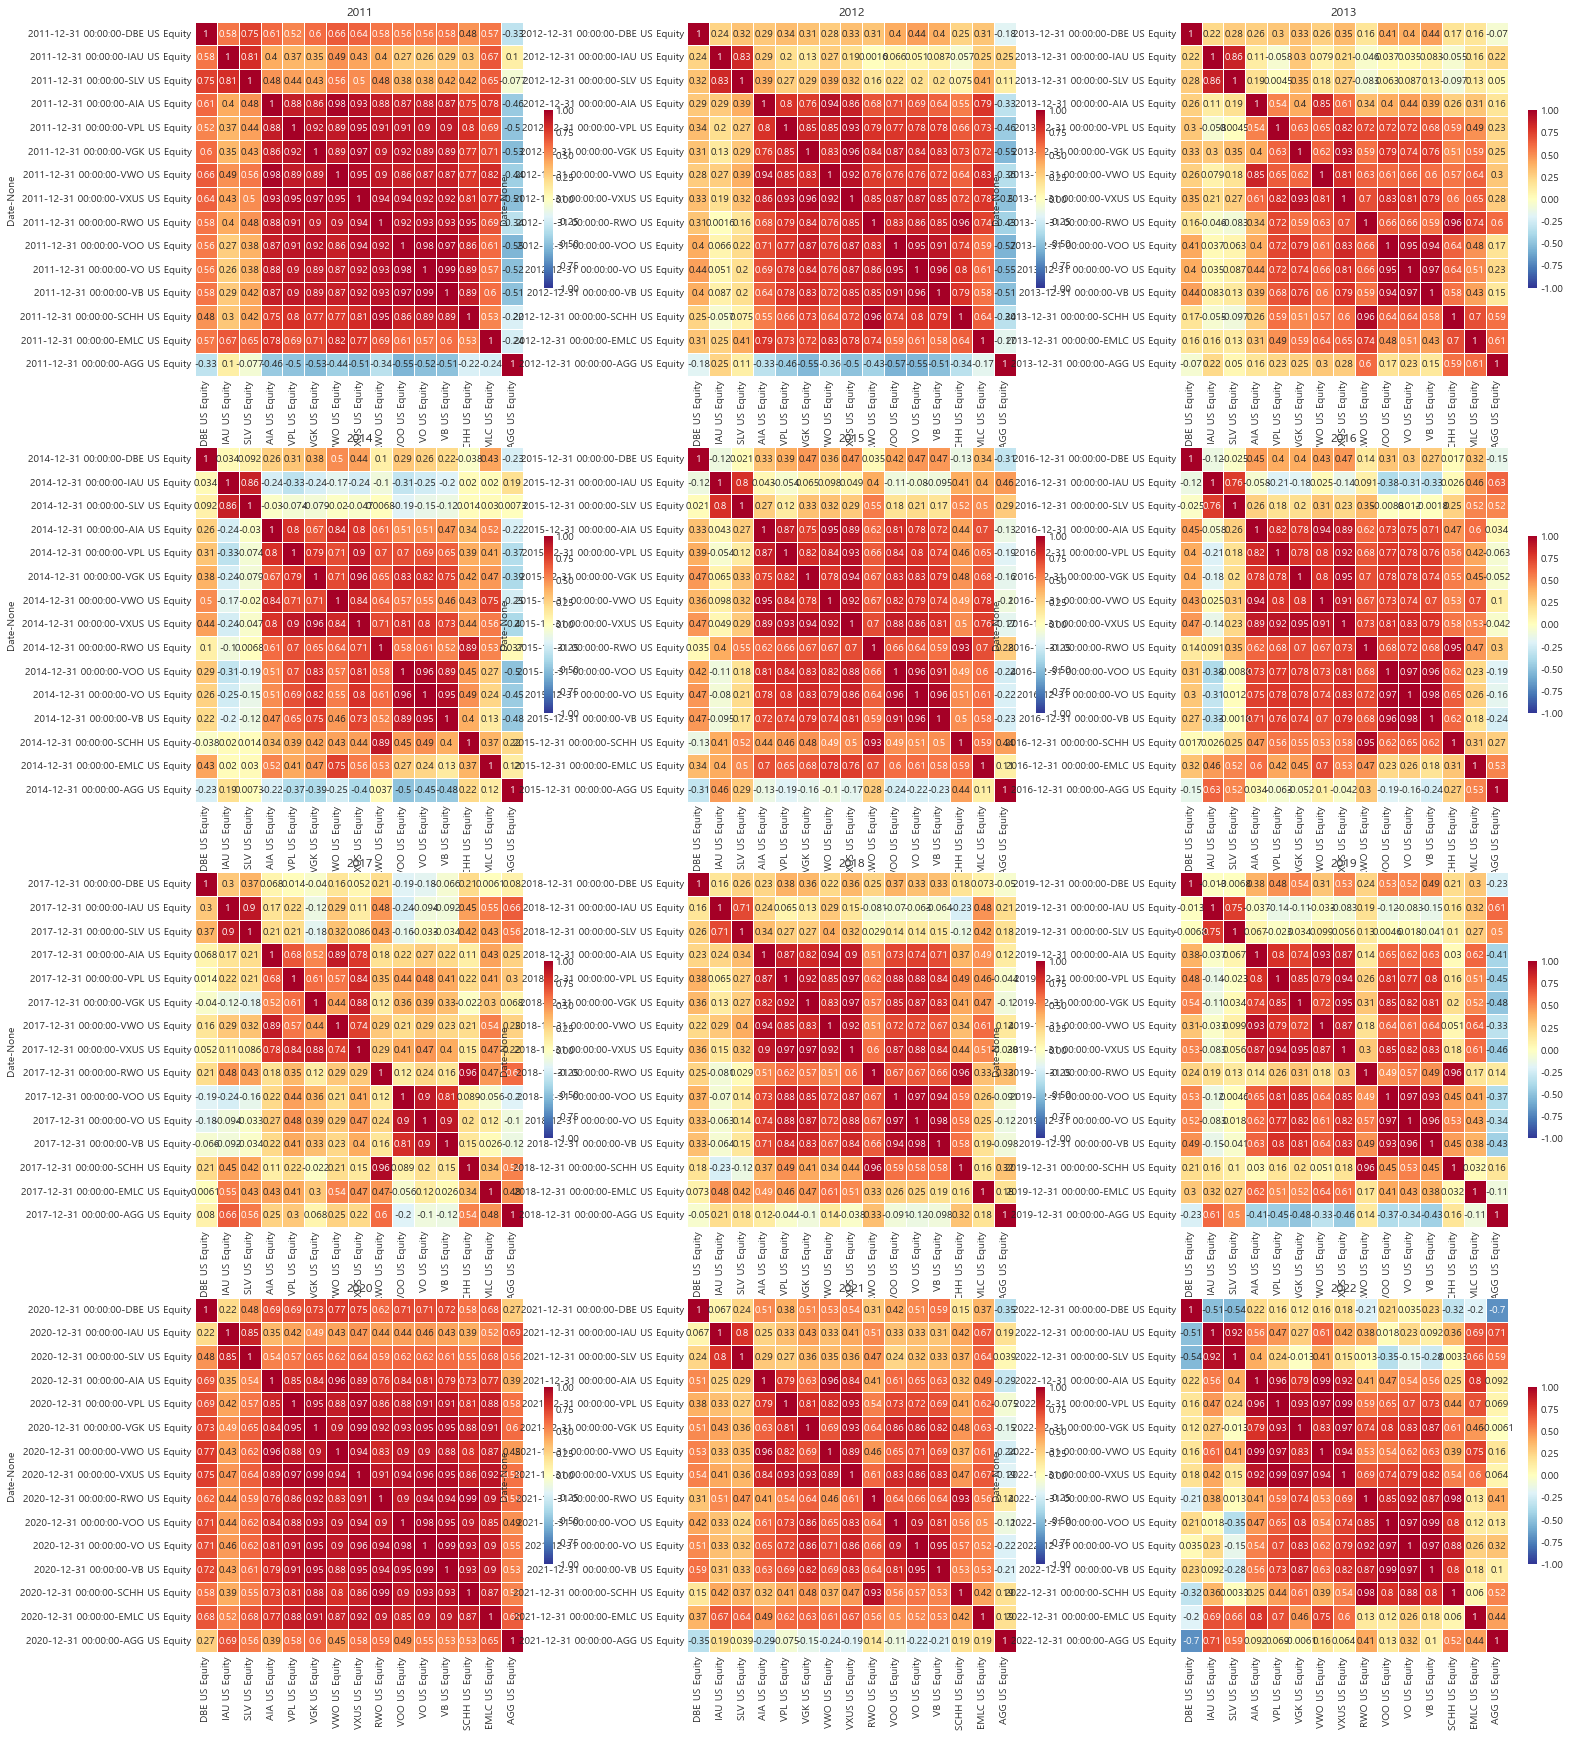

In [32]:
import seaborn as sns
# plt.figure(figsize=(12,8))
# plt.style.use('seaborn-whitegrid')
# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
dateindex = ycorr_wr.index.get_level_values('Date')
mask = np.zeros_like(ycorr_wr.loc[dateindex.year == 2011], dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

col = 3
fig, ax = plt.subplots(math.ceil(len(dateindex.year.unique())/col),col, figsize=(25,30))

for i, ye in enumerate(dateindex.year.unique()):
    x = i//col
    y = i%col
    # print(x,y)
    # 히트맵을 그린다
    sns.heatmap(ycorr_wr.loc[dateindex.year == ye], 
                cmap = 'RdYlBu_r', 
                annot = True,   # 실제 값을 표시한다
                # mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
                linewidths=.5,  # 경계면 실선으로 구분하기
                cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
                vmin = -1,vmax = 1,   # 컬러바 범위 -1 ~ 1
                ax = ax[x][y]
            )
    ax[x][y].set_title(ye)

# 전체기간 히트맵을 그린다
# sns.heatmap(corwr, 
#             cmap = 'RdYlBu_r', 
#             annot = True,   # 실제 값을 표시한다
#             mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
#             linewidths=.5,  # 경계면 실선으로 구분하기
#             cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
#             vmin = -1,vmax = 1,   # 컬러바 범위 -1 ~ 1
#             ax = ax[5][1]
#            )
# ax[5][1].set_title('전체기간')
plt.show()

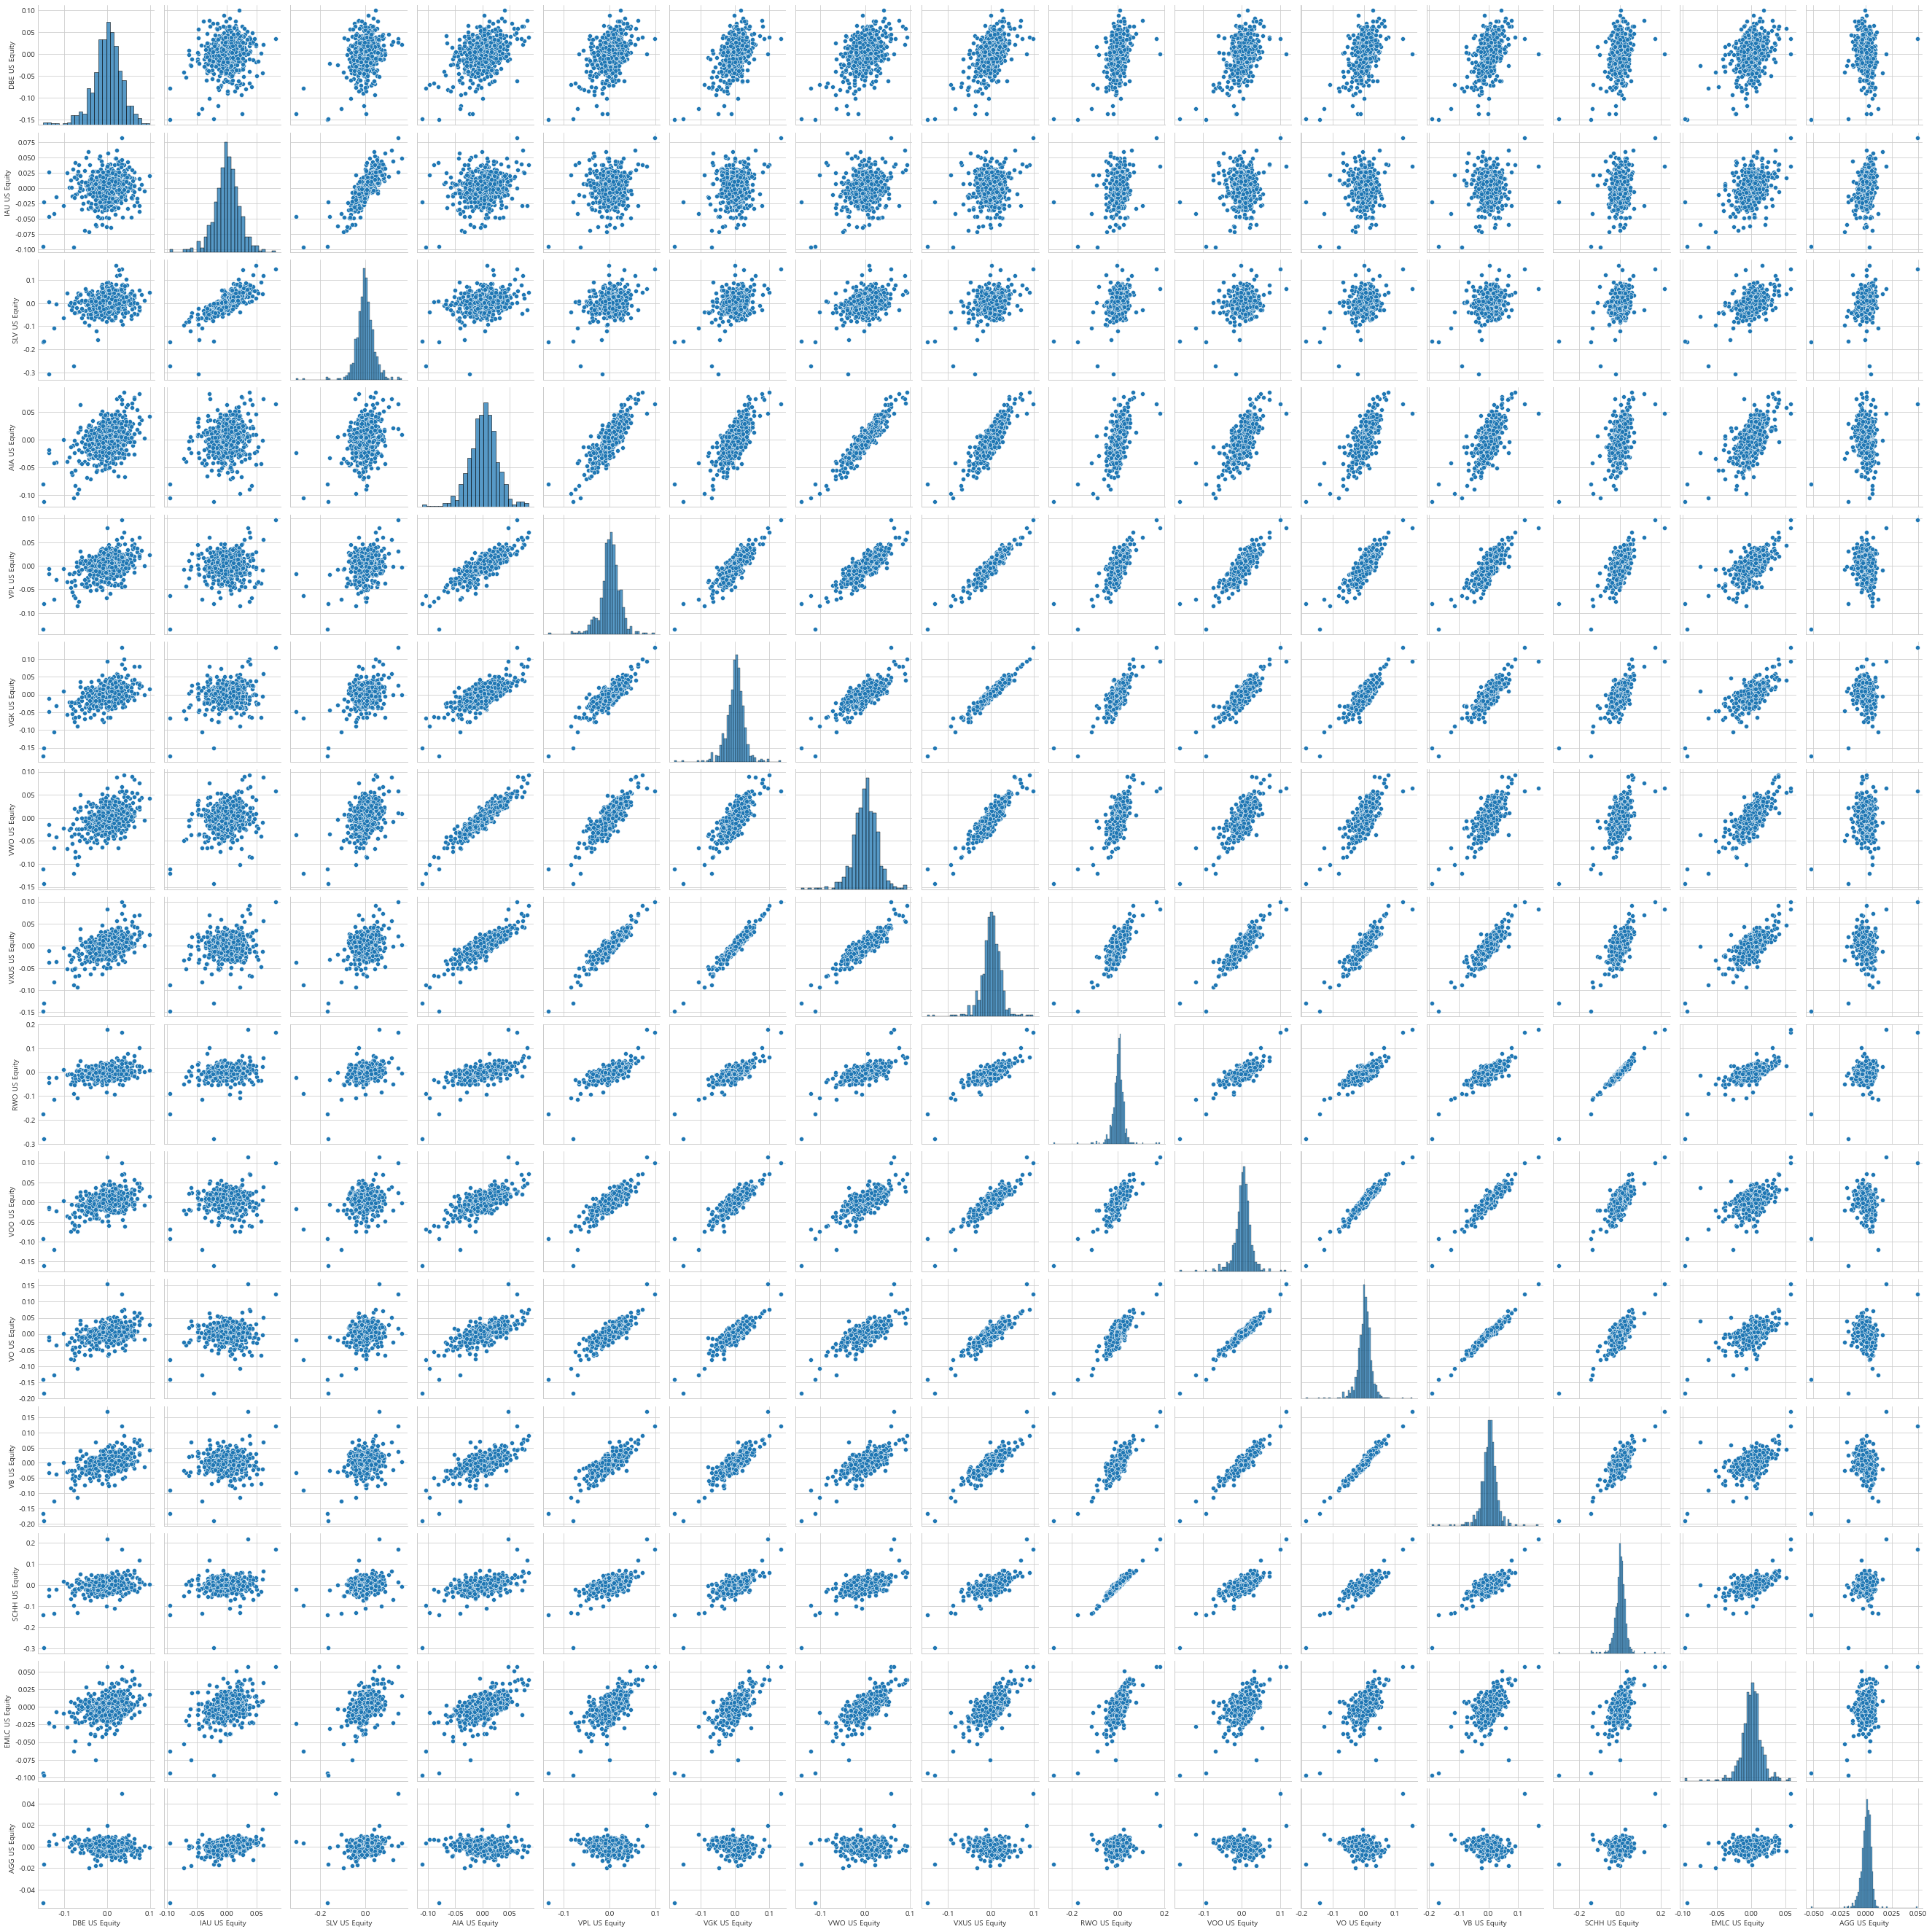

In [33]:
sns.pairplot(wr)
plt.show()

## 포트폴리오

### 포트폴리오 수익율 및 변동성

#### 우선 동일가중(equal weight)으로 연습

In [19]:
# equal weight ew 계산
num_asset = len(dr.columns)
ew = np.repeat(1/num_asset, num_asset)
ew = np.array(ew).reshape(-1,1) # 명시적으로 N*1 행렬로 변환
ew

array([[0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667],
       [0.06666667]])

In [20]:
# annualized portfolio return
apR = ew.T @ adR.values
apr = np.log(apR +1)

In [21]:
# annualized standard deviation of portfolio return
asd_pR = np.sqrt(ew.T @ acov_wR @ ew)
asd_pR

0
0  0.138691

#### 다양한 포트폴리오 최적화 방법 적용

In [22]:
type(acov_wR.values)

numpy.ndarray

In [23]:
from scipy.optimize import minimize

def obj_variance(w, cov):
    return np.sqrt(w.T @ cov @ w)

def obj_sharpe(w, r, cov, rf):
    ret = w.T @ r
    vol = np.sqrt(w.T @ cov @ w)
    # return 1/((ret-rf)/np.sqrt(vol))
    return 1/((ret-rf)/vol) # Sharpe ratio의 역수를 최소화

def obj_risk_parity(w, cov):
    num_asset = len(w)
    ew = np.repeat(1/num_asset, num_asset)
    ew = np.array(ew).reshape(-1,1) # 명시적으로 N*1 행렬로 변환
    variance = (w.T @ cov @ w)
    # print("variance: ", variance)
    sigma = np.sqrt(variance)
    # print("sigma: ", sigma)
    mrc = (cov @ w) / sigma
    # print("mrc: ", mrc)
    rc = w * mrc
    # print("rc: ", rc)
    rrc = rc / sigma
    # print("rrc: ", rrc)
    risk_diffs = rrc.values - ew
    # print("risk_diffs: ", risk_diffs)
    sum_risk_diffs_squared = np.sum(np.square(risk_diffs))
    
    # rc_ratio = rc / np.sum(rc)
    # risk_diffs = rc_ratio - w
    # sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
    # sum_risk_diffs_squared = np.sum(np.square(sigma/9 -rc))
    return sum_risk_diffs_squared

def obj_equal_weight(w):
    num_asset = len(w)
    ew = np.repeat(1/num_asset, num_asset)
    ew = np.array(ew).reshape(-1,1) # 명시적으로 N*1 행렬로 변환
    sum_weight_diffs_squared = np.sum(np.square(w-ew))
    return sum_weight_diffs_squared
# covmat=cov_daily*250
# w =np.array([0.2, 0.2, 0.2, 0.2, 0.2])
# bnds = ((0,1), (0,1), (0,1), (0,1), (0,1))
# cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
# res = minimize(obj_variance, w,(covmat), method='SLSQP', bounds=bnds, constraints=cons)

In [24]:
result_dict = {}
# 최소분산 포트폴리오 최적화
# rf = 0.01
# weights = np.ones([num_asset])/num_asset
bnds = tuple((0., 1.) for i in range(num_asset))
cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}) 
rf = 0.01 # risk-free rate 는 1%로 가정 (Maximum Sharpe 에서 사용)
# res = minimize(obj_sharpe, weights,(pct_return_annual, covmat, rf), method='SLSQP', bounds=bnds, constraints=cons)
result_dict['Minimum Variance Portfolio'] = minimize(obj_variance, ew, acov_wR, method='SLSQP', bounds=bnds, constraints=cons) # Minimum Variance Optimization
result_dict['Maximum Sharpe Portfolio'] = minimize(obj_sharpe, ew,(adR, acov_wR, rf), method='SLSQP', bounds=bnds, constraints=cons)
result_dict['Risk Parity Portfolio'] = minimize(obj_risk_parity, ew, acov_wR, method='SLSQP', bounds=bnds, constraints=cons)
result_dict['Equal Weight Portfolio'] = minimize(obj_equal_weight, ew, method='SLSQP', bounds=bnds, constraints=cons)

#### 최적화 결과 plot

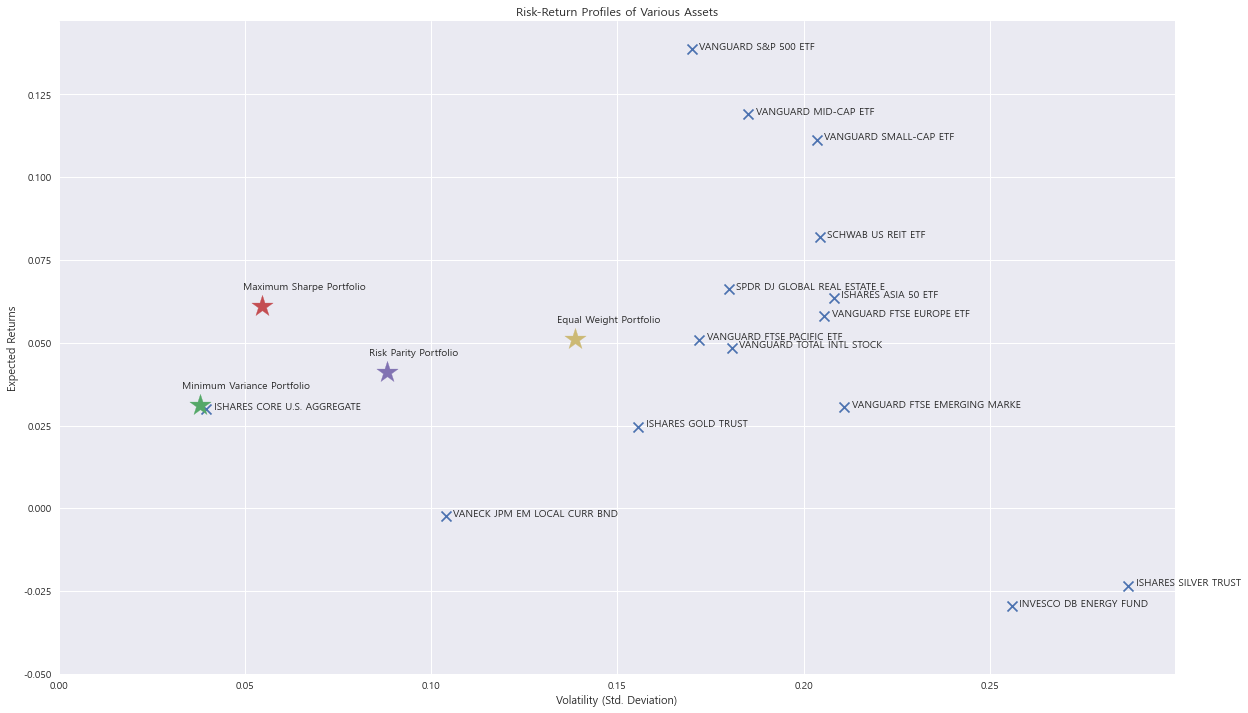

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl 
plt.figure(figsize=(20,12))
plt.style.use('seaborn')
# plt.style.use('seaborn-whitegrid')
plt.rc('font', family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.scatter(asd_dR, adR, marker="x", s=100, alpha=1.0)
for i, label in enumerate(adR.index):
    plt.text(asd_dR[i]+0.002, adR[i], label)
plt.xlim(left=0)
plt.ylim(bottom=-0.05)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Risk-Return Profiles of Various Assets')


for k, v in result_dict.items():
    ret = np.sum(adR * v['x'])
    vol = np.sqrt(v['x'].T @ acov_wR @ v['x'])
    plt.scatter(vol, ret, marker="*", s=500, alpha=1.0)
    plt.text(vol-0.005, ret+0.005, k)




plt.show()

### wealth index
시작시점의 가격,보유금액,지수 등을 1000으로 보고 포트폴리오의 가치변동 계산

In [26]:
df_p_cdR = pd.DataFrame({k: cdR @ v['x'] for k, v in result_dict.items()})
df_p_cdR

Minimum Variance Portfolio  Maximum Sharpe Portfolio  \
Date                                                               
2011-01-31                   -0.001214                  0.000850   
2011-02-01                   -0.002593                  0.003849   
2011-02-02                   -0.003427                  0.002547   
2011-02-03                   -0.006968                  0.000647   
2011-02-04                   -0.010304                 -0.000935   
...                                ...                       ...   
2022-01-21                    0.444611                  1.218935   
2022-01-24                    0.443200                  1.222893   
2022-01-25                    0.440925                  1.206986   
2022-01-26                    0.433075                  1.198668   
2022-01-27                    0.436561                  1.195803   

            Risk Parity Portfolio  Equal Weight Portfolio  
Date                                                       
2011-01-31               0.003208                0.007084  
2011-02-01               0.010096                0.019930  
2011-02-02               0.008975                0.018434  
2011-02-03               0.009820                0.021751  
2011-02-04               0.007872                0.020600  
...                           ...                     ...  
2022-01-21               0.727966                0.991933  
2022-01-24               0.728233                0.993398  
2022-01-25               0.719737                0.979175  
2022-01-26               0.706490                0.962516  
2022-01-27               0.696577                0.942998  

[2768 rows x 4 columns]

<AxesSubplot:xlabel='Date'>

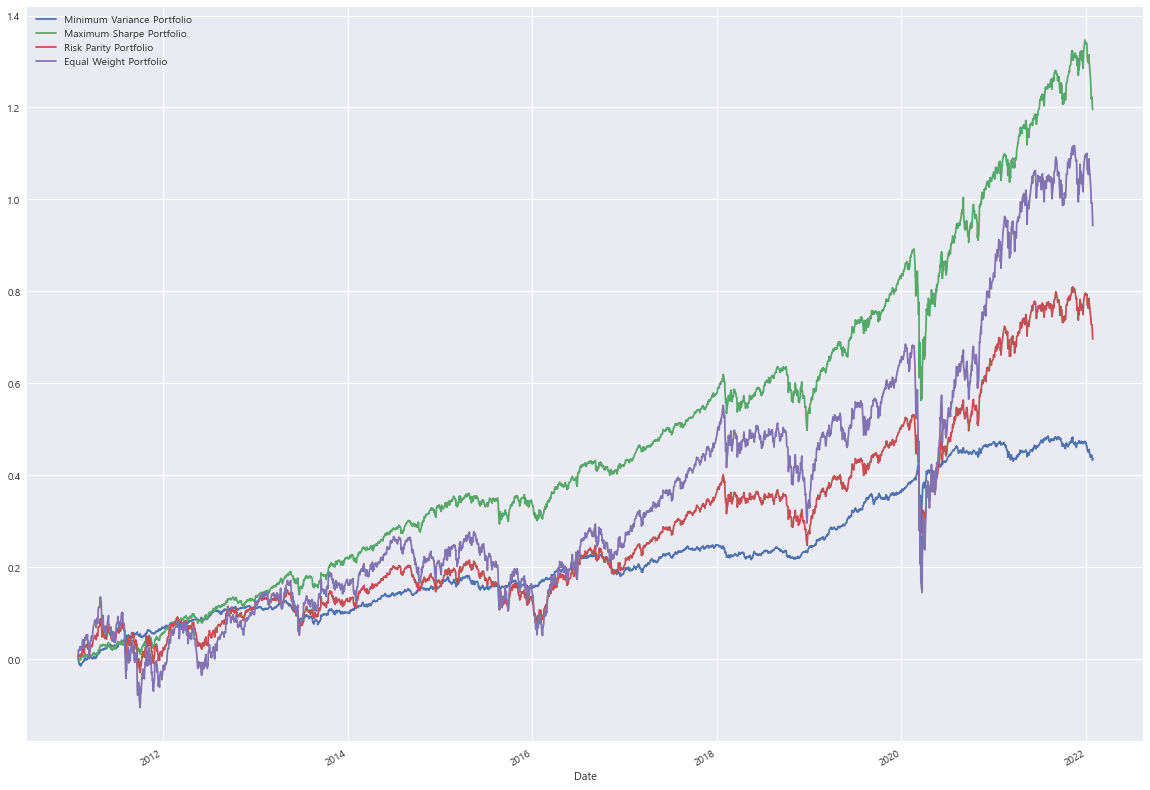

In [27]:
df_p_cdR.plot(figsize=(20,15))

<AxesSubplot:xlabel='Date'>

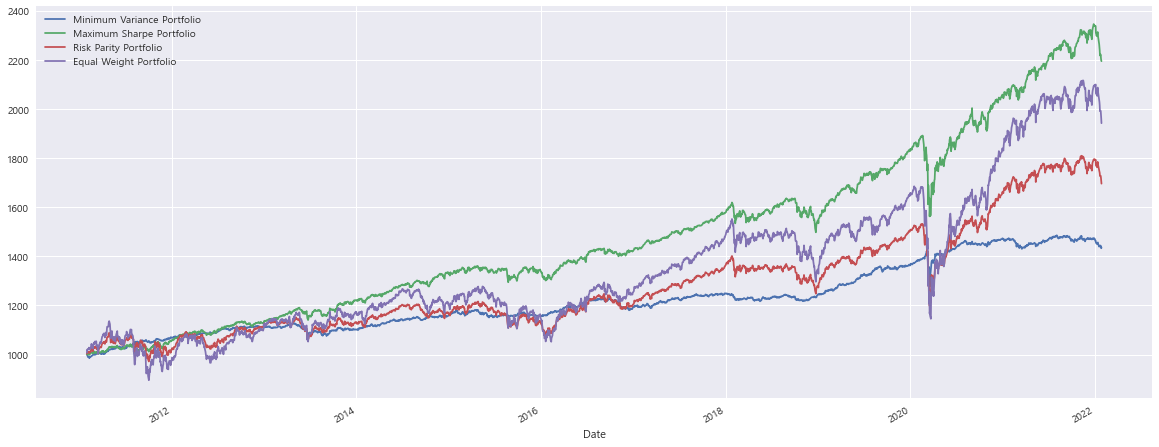

In [28]:
wealth_index = 1000 * (1+df_p_cdR) # 누적 기간 수익율에 기초자산금액 1000을 곱함
wealth_index.plot(figsize=(20,8))

### previous peak(직전 고점)
Drawdown 을 구하기 위한 과정

<AxesSubplot:xlabel='Date'>

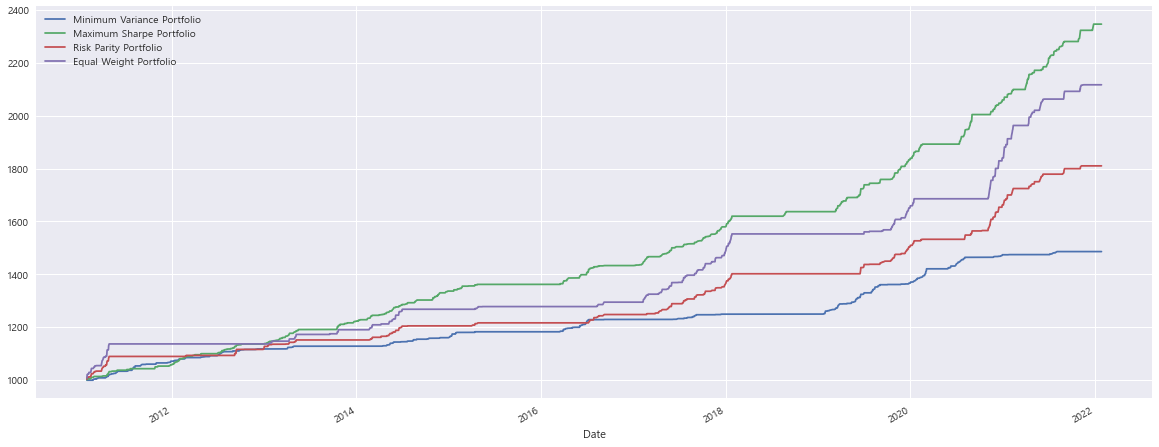

In [29]:
previous_peaks = wealth_index.cummax() # pandas 의 cummax() 메소드 활용
previous_peaks.plot(figsize=(20,8))

### drawdown
현재가 - 직전고점

<AxesSubplot:xlabel='Date'>

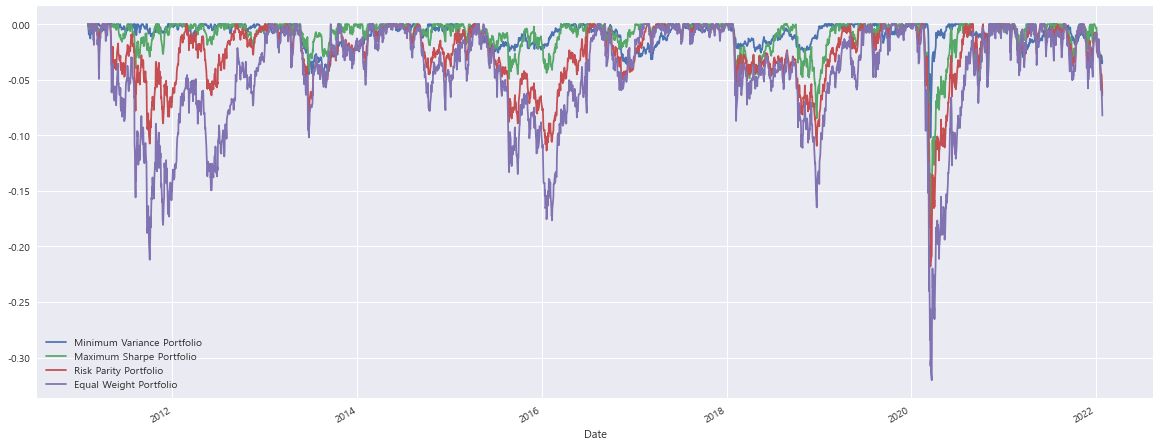

In [30]:
drawdown = (wealth_index - previous_peaks) / previous_peaks
drawdown.plot(figsize=(20,8))

### MDD : Maximum Drawdown

In [31]:
maximum_drawdown = drawdown.min() # drawdown 중 가장 작은 값
maximum_drawdown

Minimum Variance Portfolio   -0.102256
Maximum Sharpe Portfolio     -0.174030
Risk Parity Portfolio        -0.218102
Equal Weight Portfolio       -0.320385
dtype: float64

In [32]:
drawdown["2021":].min() # 2021년 이후 maximum drawdown

Minimum Variance Portfolio   -0.035428
Maximum Sharpe Portfolio     -0.064328
Risk Parity Portfolio        -0.062769
Equal Weight Portfolio       -0.082248
dtype: float64

In [33]:
drawdown.idxmin() # drawdown 중 가장 작은 값이 나온 시점 (max drawdown 시점)

Minimum Variance Portfolio   2020-03-18
Maximum Sharpe Portfolio     2020-03-18
Risk Parity Portfolio        2020-03-18
Equal Weight Portfolio       2020-03-23
dtype: datetime64[ns]

In [52]:
wealth_index_pct = 1000 * (pct_ret + 1).cumprod() # 누적 기간 수익율에 기초자산금액 1000을 곱함
wealth_index_pct.plot(figsize=(20,8))

wealth_index = 1000 * np.exp(log_ret.cumsum()) # 누적 기간 수익율에 기초자산금액 1000을 곱함
wealth_index.plot(figsize=(20,8))

NameError: name 'pct_ret' is not defined

In [ ]:
previous_peaks = wealth_index.cummax() # pandas 의 cummax() 메소드 활용
previous_peaks.plot(figsize=(20,8))

In [ ]:
drawdown = (wealth_index - previous_peaks) / previous_peaks
drawdown.plot(figsize=(20,8))

In [ ]:
maximum_drawdown = drawdown.min() # drawdown 중 가장 작은 값
maximum_drawdown

In [ ]:
pfo_rets = []
pfo_vols = []
pfo_wgts = []

num_pfos = 100000

for s in range(num_pfos):
  wgt = np.random.random(num_asset)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, log_ret_annual)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  pfo_rets.append(ret)
  pfo_vols.append(vol)
  pfo_wgts.append(wgt)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl 
pfo_vols = np.array(pfo_vols)
pfo_rets = np.array(pfo_rets)
colors = pfo_rets/pfo_vols
plt.style.use('seaborn')
plt.figure(figsize=(20,12))
plt.scatter(pfo_vols, pfo_rets, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(log_ret.std()*np.sqrt(250), log_ret_annual, marker="x", s=100, alpha=1.0)
for i, label in enumerate(log_ret_annual.index):
    plt.text(log_ret.std()[i]*np.sqrt(250), log_ret_annual[i]+0.002, label)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
rets = np.sum(pct_return_annual * res['x'])
vol = np.sqrt(res['x'].T @ covmat @ res['x'])
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.xlim([0, 0.2])
plt.ylim([0, 0.15])
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(i_vol, i_ret, marker="x", s=100, alpha=1.0)
plt.scatter(vol, rets, marker="*", s=500, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
from scipy.optimize import minimize

def obj_sharpe(weights, returns, covmat, rf):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))
    # return 1/((ret-rf)/np.sqrt(vol))
    return 1/((ret-rf)/vol)

In [ ]:
# n_assets = len(columns)
# covmat=cov_daily*250
rf = 0.01
weights = np.ones([num_asset])/num_asset
bnds = tuple((0., 1.) for i in range(num_asset))
cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}) 
res = minimize(obj_sharpe, weights,(log_ret_annual, cov_annual_weekly, rf), method='SLSQP', bounds=bnds, constraints=cons)

In [ ]:
p_returns = []
p_volatility = []
p_weights = []

n_assets = len(columns)
n_ports = 30000

for s in range(n_ports):
  wgt = np.random.random(n_assets)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, pct_return_annual)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(wgt)

In [ ]:
# rets = np.sum(pct_return_daily.mean() * res['x']) * 250
rets = np.sum(pct_return_annual * res['x'])
vol = np.sqrt(res['x'].T @ covmat @ res['x'])
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.xlim([0, 0.2])
plt.ylim([0, 0.15])
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, rets, marker="*", s=500, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
np.sqrt(cov_annual)

In [ ]:
res['x'].round(10)

In [ ]:
from scipy.optimize import minimize

def obj_variance(weights, cov):
    return np.sqrt(weights.T @ covmat @ weights)

# covmat=cov_daily*250
# weights =np.array([0.2, 0.2, 0.2, 0.2, 0.2])
# bnds = ((0,1), (0,1), (0,1), (0,1), (0,1))
# cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
# res = minimize(obj_variance, weights,(covmat), method='SLSQP', bounds=bnds, constraints=cons)

In [ ]:
n_assets = len(columns)
covmat=cov_daily*250
rf = 0.01
weights = np.ones([n_assets])/n_assets
bnds = tuple((0., 1.) for i in range(n_assets))
cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}) 
# res = minimize(obj_sharpe, weights,(pct_return_annual, covmat, rf), method='SLSQP', bounds=bnds, constraints=cons)
res = minimize(obj_variance, weights,(covmat), method='SLSQP', bounds=bnds, constraints=cons)

In [ ]:
print(res)

In [ ]:
res['x'].round(4)

In [ ]:
p_returns = []
p_volatility = []
p_weights = []

n_assets = len(columns)
n_ports = 10000

for s in range(n_ports):
  wgt = np.random.random(n_assets)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, pct_return_annual)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(wgt)

In [ ]:
vol_annual = pct_return_daily.std() * np.sqrt(250)

In [ ]:
i_vol = np.array(vol_annual)
i_ret = np.array(pct_return_annual)

In [ ]:
rets = np.sum(pct_return_annual * res['x'])
vol = np.sqrt(res['x'].T @ covmat @ res['x'])
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.xlim([0, 0.2])
plt.ylim([0, 0.15])
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(i_vol, i_ret, marker="x", s=100, alpha=1.0)
plt.scatter(vol, rets, marker="*", s=500, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
cov_annual.to_csv('cov_annual.csv')

In [ ]:
# 기간별 누적수익율

#1) 일반 수익율
cum_pct_ret = (pct_ret + 1).cumprod()-1

#2) 로그 수익율
cum_log_ret = log_ret.cumsum()

cum_pct_ret.plot(figsize=(20,8), title='Cumulative Percent Return')
cum_log_ret.plot(figsize=(20,8), title='Cumulative Log Return')


## 포트폴리오 성과 측정

In [ ]:
log_ret.info()

In [ ]:
log_ret.describe()

In [ ]:
log_ret.std() # sample standard deviation